# Analyzing and predicting the ridership of CTA trains
In this project, we aim to analyze the CTA rail commuter travel patterns from 2001 to 2019 and predict the ridership for 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import datetime
import calendar 
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.svm import SVR
from statsmodels.tsa.api import VAR

In [2]:
#Reading the file for daily ridership of the L 
# os.chdir(r"C:\Users\kastu\Documents\UIC\Spring '20\IDS\Project\dataset")
L_daily=pd.read_csv("./data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv")

### Data cleaning and Exploratory Data Analysis
The data cleaning and EDA performed to analyze and visualize the data:
- Added a day column using the datetime library to analyze day wise trends in rail ridership
- Aggregated over each day of the week to calculate the mean ridership for each day of the week.
- Added a year column to analyze yearwise ridership
- Aggregate over years to see the trends in CTA stations
- Checked if NULL values were present

In [3]:
#Checking the dataframe columns and contents
L_daily.head()

,station_id,stationname,date,daytype,rides
0,40850,Library,10/09/2004,A,1057
1,40780,Central Park,06/18/2010,W,1154
2,41500,Montrose-Brown,10/30/2001,W,2116
3,40500,Washington/State,10/26/2006,W,0
4,41090,Monroe/State,07/07/2010,W,9431


In [4]:
#Checking the statistics of ridership
L_daily.describe()

,station_id,rides
count,988858.000000,988858.000000
mean,40763.358237,3322.844864
std,447.169160,3215.420986
min,40010.000000,0.000000
25%,40370.000000,1123.000000
50%,40750.000000,2324.000000
75%,41150.000000,4351.000000
max,41700.000000,36323.000000


In [5]:
# Adding day column to see how ridership varies by the day
day= []
for index, value in L_daily['date'].items():
    week_day= datetime.datetime.strptime(value, '%m/%d/%Y').weekday() 
    day.append(calendar.day_name[week_day])
L_daily['Day']=day

In [6]:
# Adding year column to aggregate over years to analyze trends in ridership
L_daily['year'] = pd.DatetimeIndex(L_daily['date']).year

In [7]:
# Checking for missing values in the data
L_daily.isna()

,station_id,stationname,date,daytype,rides,Day,year
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
988853,False,False,False,False,False,False,False
988854,False,False,False,False,False,False,False
988855,False,False,False,False,False,False,False
988856,False,False,False,False,False,False,False


In [8]:
# Calculating the mean ridership for each day of the week for each bus
L_daily_mod=L_daily.loc[:,['Day','rides','year']]
L_daily_mod=L_daily_mod.loc[L_daily_mod["year"]>2014,:]

pivot=L_daily_mod.pivot_table(values="rides", index=["Day","year"], dropna=True, fill_value=0, aggfunc="mean")
pivot['year'] = pivot.index
pivot['Day'] = pivot.index
l = []
s=[]
for index, value in pivot['year'].items():
    l.append(value[1])
    s.append(value[0])
pivot['year'] = l
pivot['Day'] = s

### The CTA train ridership has plummeted not just on weekends due to office holidays but also on weekdays due to the commuter movement to other competetive trains like metra 

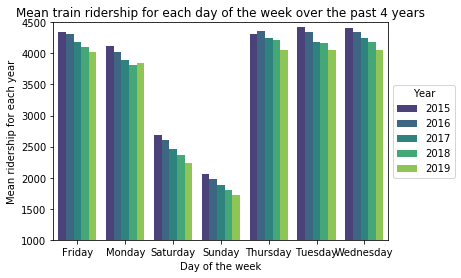

In [9]:
y=sns.barplot(x="Day",y="rides",hue="year",data=pivot,palette="viridis")
plt.ylim(1000, 4500)
plt.legend(title='Year',loc='center left',bbox_to_anchor=(1,0.5))
plt.xlabel("Day of the week")
plt.ylabel("Mean ridership for each year")
plt.title("Mean train ridership for each day of the week over the past 4 years")
plt.show()

### DESCRIPTION:
The hypothesis about the decline in CTA train ridership is true. One reason could be because most of the commuters take the train only for office. But this decline can be observed on all days of the week. The reason of this decline could be because of the increase in popularity of Metra since 2017, especially in the southern parts of Chicago. Another possible reason could be that CTA increased the price of passes without increasing the price of a single ride in 2014. Hence, it could have lost many customers who used CTA on a daily basis. Also, in 2015, CTA introduced new permanent Ventra card system, replacing the disposable passes. This was confusing for the general public at the time. These two factors could have resulted in the decline in the use of the rail over the past 4 years. 

In [10]:
# EDA and slicing
L_year=L_daily.loc[:,['year','rides','stationname','station_id']]
pt=L_year.pivot_table(values="rides", index=["stationname","year"], dropna=True, fill_value=0, aggfunc="mean" )
pt['year'] = pt.index
pt['stationname'] = pt.index
l = []
s=[]
for index, value in pt['year'].items():
    l.append(value[1])
    s.append(value[0])
pt['year'] = l
pt['stationname'] = s
current_year = 2001
L_year_mod = pt[pt['year'].eq(current_year)].sort_values(by='rides', ascending=False).head(10)

In [11]:
# Animated bar plot 
def draw_barchart(year):
    dff = pt[pt['year'].eq(year)].sort_values(by='rides', ascending=False).head(10)
    ax.clear()
    ax.barh(dff['stationname'], dff['rides'])
    dx = dff['rides'].max() / 200
    for i, (value, name) in enumerate(zip(dff['rides'], dff['stationname'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    # ... polished styles
    ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'rides', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.10, 'The most popular train stations in Chicago from 2001 to 2019',
            transform=ax.transAxes, size=24, weight=600, ha='left')  
    ax.text(0, 1.17, 'Note: Please hit the front arrow -> button to start the animation',
            transform=ax.transAxes, size=14, weight=600, ha='left')  
    plt.box(False)

### Hypothesis:
### The commuter mobility has shifted from South Chicago to the downtown due to boom in the Chicago Loop and saturation of  train lines in the loop

### DESCRIPTION 
#### The souhtern train station like 95th/Dan Ryan which was the most popular in 2001  is nowhere in the top 10 in 2019
The 95th Dan/Ryan station was popular as it was the last red line station and it had a connection to the Greyhound station. 
- This station became less popular because the ridership in th 21st century grew in the downtown area due to the business boom in the loop area. Due to this, population of Chicago has moved from south to the north.

#### Stations like Clark/Lake and Lake/state have the highest ridership since the past 10 years.
- This is also because of the boom in the business sector in the loop. 
- Another reason for the constantly high ridership of State/Lake and other stations in the loop could be because all the 8 lines run on the stations in the loop area. Commuters of all these lines use the stations. Whereas for the non-loop stations, only one, two or maximum three lines pass through a single station.
- The stations in the loop provide an opportunity for commuters to move from one line to the other at the same station. Hence, it is easier for them to travel anywhere. This could be another reason for the constantly high ridership in these areas.

These findings can be confirmed from the animated bar plot below.

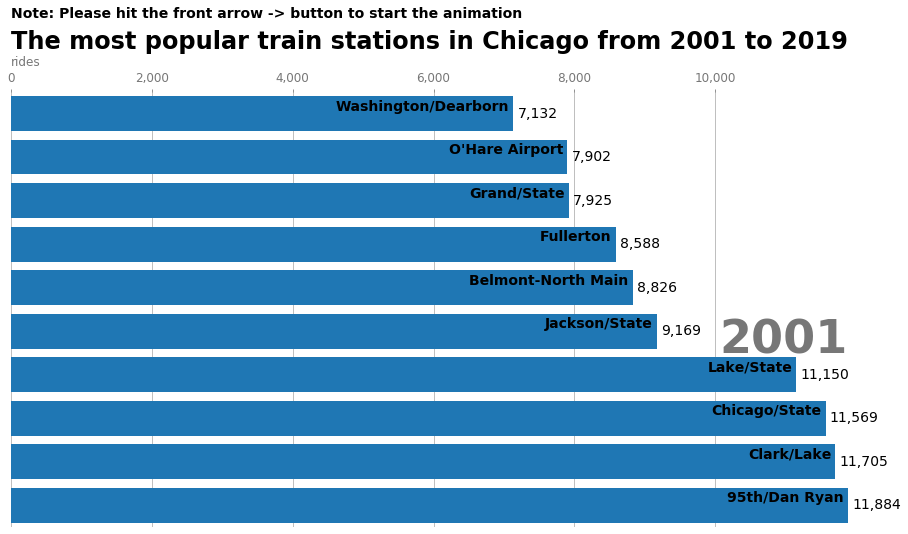

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(2001, 2020))
HTML(animator.to_jshtml()) 

### Machine Learning

In [13]:
#Reading the file in which necessary features were extracted to perform Machine learning analysis
data = pd.read_csv("https://raw.githubusercontent.com/uic-cs418/python_demons/master/data/trains_dataset.csv?token=ALPRHXIGDMW2TJGZ3E77MZK6SZQ26", error_bad_lines=False)
data.head()
data.size

10848

The aim of the project is to predict the ridership in the rail system for the year 2020. 
This can be done by training on the CTA rail data from 2001 to 2018 and testing on 2019. Then calculating the loss by comparing the predicted ridership for 2019 with the actual ridership, optimizing and tuning the hyperparameters and then predicting the ridership for 2020.
To do this, support vector regression is performed as a baseline classifier to predict the ridership for 2019.
To analyze time series data, it is best to use algorithms like Seasonal ARIMA or LSTM. Another alternative could be Vector Autoregression, since the data is multivariate time series data.

### Support vector regression to predict the 2019 ridership

The support vector regression would not perform well to predict the ridership based on the past data as there is not much correlation between the features( ridership for each year from 2001-2018 and station name) and the output label, that is mean ridership. But this could work as a good baseline for more complex models

In [14]:
test=data.loc[data["year"]==2019]
X_test=test.iloc[:,1:3]
y_test=test.iloc[:,3]
train=data.loc[data["year"]<2019,:]
X=train.iloc[:,1:3]
y=train.iloc[:,3]
clf = SVR(gamma='scale')
clf=clf.fit(X, y)

In [15]:
y_test = y_test.reset_index(drop=True)
y_pred = clf.predict(X_test)

In [16]:
final=pd.DataFrame()
final["predicted"]=y_pred
final["actual"]=y_test
final.tail(10)

,predicted,actual
134,74917.964209,78945.0
135,74917.962164,104838.0
136,74917.961142,101043.0
137,74917.960120,66130.0
138,74917.959098,92091.0
139,74917.943776,537570.0
140,74917.942755,23227.0
141,74917.941734,22913.0
142,74917.940713,47060.0
143,74917.939693,260506.0


By inspecting the head of the data frame we can see how bad SVR is performing on the data as anticipated. It is revolving about two values for each station. The r2 score for this was -0.09. Hence, I chose to try Vector Autoregression, since it is a multivariate time series data.

In [17]:
a2=data.pivot_table(values='avg_ridership', index='station_id',columns='year', aggfunc=np.sum)
a2= a2.dropna()
a2['station_id'] = a2.index

In [18]:
model = VAR(a2)
results = model.fit()
results.summary()

C:\Users\kastu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Apr, 2020
Time:                     21:08:23
--------------------------------------------------------------------
No. of Equations:         20.0000    BIC:                    354.531
Nobs:                     139.000    HQIC:                   349.268
Log likelihood:          -27548.3    FPE:               1.38158e+150
AIC:                      345.664    Det(Omega_mle):    8.28462e+148
--------------------------------------------------------------------
Results for equation 2001
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const            200392.476536    589371.901546            0.340           0.734
L1.2001               3.421883         1.482570            2.308           0.021
L1.2002              -3.712926         1.910115           -1.